<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/split_experiments/dnn/variational_split_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DNN regressors

A variational model to find the mean/variance of O18 ratios at a particular lat/lon in the Brazilian Amazon. At the bottom of the colab, there are utilities to generate isoscapes from this model.

In [25]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
from typing import List, Tuple, Dict

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = None #@param
MODEL_SAVE_LOCATION = "/usr/local/google/home/ruru/Downloads/variational/variational/model/" #@param

def format_dataframe_path(param) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{param}"

def get_model_save_location(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{MODEL_SAVE_LOCATION}{filename}"

# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

#Data preparation


In [9]:
def load_dataset(path: str):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]

  # Family is too sparse. Too many families exist in validation/test that won't
  # exist in train, so drop it.
  X = df.drop(["d18O_cel_mean", "d18O_cel_variance", "Code", "Family", "Unnamed: 0"], axis=1)
  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  return X, Y

Standardization

In [22]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer

def create_feature_scaler(X: pd.DataFrame):
  columns_to_normalize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
       'Mean Annual Temperature', 'Mean Annual Precipitation',
       'Iso_Oxi_Stack_mean_TERZER', 'predkrig_br_lat_ISORG',
       'isoscape_fullmodel_d18O_prec_REGRESSION']
  feature_scaler = ColumnTransformer([
      ('feature_normalizer', Normalizer(), columns_to_normalize)],
      remainder='passthrough')
  feature_scaler.fit(X)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame):
  # CODE REVIEW QUESTION: Standardization of variances will produce negative
  # variances. Any workarounds or should I just not try it?
  label_scaler = ColumnTransformer([
      ('label_std_scaler', StandardScaler(), ['d18O_cel_mean'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, Y: pd.DataFrame, feature_scaler, label_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  Y_standardized = pd.DataFrame(label_scaler.transform(Y),
                                      index=Y.index, columns=Y.columns)
  return X_standardized, Y_standardized

In [23]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
class ScaledDataset():
  def __init__(self, feature_scaler, label_scaler,
               X_train = None, X_val = None, X_test = None,
               Y_train = None, Y_val = None, Y_test = None):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.X_train = X_train
    self.X_val = X_val
    self.X_test = X_test
    self.Y_train = Y_train
    self.Y_val = Y_val
    self.Y_test = Y_test


def load_and_scale(config: Dict) -> ScaledDataset:
  X_train, Y_train = load_dataset(format_dataframe_path(config['TRAIN']))
  X_val, Y_val = load_dataset(format_dataframe_path(config['VALIDATION']))
  X_test, Y_test = load_dataset(format_dataframe_path(config['TEST']))

  feature_scaler = create_feature_scaler(X_train)
  label_scaler = create_label_scaler(Y_train)
  X_train_scaled, Y_train_scaled = scale(X_train, Y_train, feature_scaler, label_scaler)
  X_val_scaled, Y_val_scaled = scale(X_val, Y_val, feature_scaler, label_scaler)
  X_test_scaled, Y_test_scaled = scale(X_test, Y_test, feature_scaler, label_scaler)
  return ScaledDataset(
      feature_scaler, label_scaler,
      X_train=X_train_scaled, X_val=X_val_scaled, X_test=X_test_scaled,
      Y_train=Y_train_scaled, Y_val=Y_val_scaled, Y_test=Y_test_scaled)


# Model Definition



The KL Loss function:

In [13]:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence(real, predicted):
    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))

    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

def symmetric_kl(real, predicted):
  return kl_divergence(real, predicted)

Test the loss function:

In [ ]:
import pytest

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

Model definition

In [52]:
from keras.callbacks import ModelCheckpoint

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=1000, min_delta=0.001, verbose=1,
    restore_best_weights=True, start_from_epoch=0)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_vars(X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        validation_data: Tuple[pd.DataFrame, pd.DataFrame],
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [early_stop, get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(1, name='var_output')(x)
    abs_var = keras.layers.Lambda(lambda t: tf.abs(t))(var_output)

    # Output mean, |variance| tuples.
    outputs = keras.layers.concatenate([mean_output, abs_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=100, decay_rate=0.5, staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=symmetric_kl)
    model.summary()
  else:
    model = keras.models.load_model(get_model_save_location(model_file),
                                    custom_objects={"symmetric_kl": symmetric_kl})
  history = model.fit(X, Y, verbose=1, epochs=epochs, batch_size=batch_size,
                      validation_data=validation_data, shuffle=True, callbacks=callbacks_list)
  return history, model

In [43]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledDataset, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['label_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sd: ScaledDataset, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, vars_model = train_vars(sd.X_train, sd.Y_train, hidden_layers=[20, 20],
                                 epochs=5000, batch_size=training_batch_size,
                                 lr=0.0001, validation_data=(sd.X_val, sd.Y_val),
                                 model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  vars_model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  vars_model.evaluate(x=sd.X_test, y=sd.Y_test)
  predictions = vars_model.predict_on_batch(sd.X_test)
  print("EXPECTED:")
  Y_destandardized = destandardize(sd, sd.Y_test)
  print(Y_destandardized.to_string())
  print()
  print("PREDICTED:")
  predictions =  destandardize(sd, pd.DataFrame(predictions, columns=['d18O_cel_mean', 'd18O_cel_variance']))
  print(predictions.to_string())

  rmse = np.sqrt(mean_squared_error(Y_destandardized['d18O_cel_mean'], predictions['d18O_cel_mean']))
  print("RMSE: "+ str(rmse))

# Load and evaluate the model with each set of data.

Use the same model configured the same way for every run, with the exception of the training batch size setting, which is 1 for grouped and 5 for ungrouped.

### 1) Ungrouped, random

ungrouped_random
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_16 (Dense)               (None, 20)           260         ['input_9[0][0]']                
                                                                                                  
 dense_17 (Dense)               (None, 20)           420         ['dense_16[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_17[0][0]']               
                                                                           

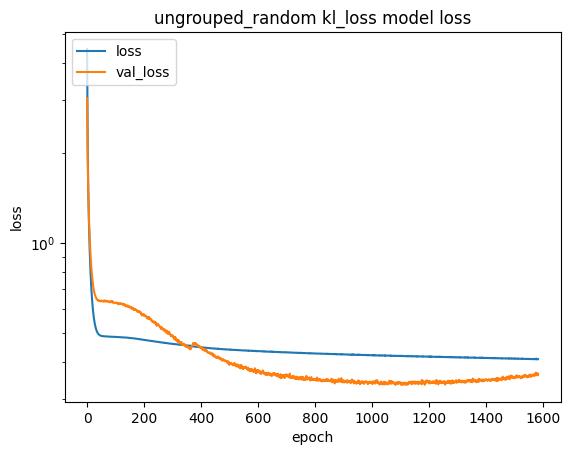

2/2 [==============================] - 0s 2ms/step - loss: 1.8904
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       26.663818           0.574594
1       26.663818           0.574594
2       26.663818           0.574594
3       27.559140           0.780698
4       27.559140           0.780698
5       27.559140           0.780698
6       27.559140           0.780698
7       27.559140           0.780698
8       27.559140           0.780698
9       27.559140           0.780698
10      27.559140           0.780698
11      27.559140           0.780698
12      27.559140           0.780698
13      27.260748           0.830341
14      27.260748           0.830341
15      27.260748           0.830341
16      27.260748           0.830341
17      27.260748           0.830341
18      27.260748           0.830341
19      27.260748           0.830341
20      27.260748           0.830341
21      27.260748           0.830341
22      27.260748           0.830341
23      27.260748           0.830341

2023-07-12 20:59:31.210299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [63,12]
	 [[{{node Placeholder/_0}}]]


In [44]:
ungrouped_random = {
    'TRAIN' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_train_random_ungrouped.csv",
    'TEST' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_test_random_ungrouped.csv",
    'VALIDATION' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_validation_random_ungrouped.csv",
}

ungrouped_random_scaled = load_and_scale(ungrouped_random)
train_and_evaluate(ungrouped_random_scaled, "ungrouped_random", training_batch_size=5)

### 2) Ungrouped, fixed

ungrouped_fixed
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 20)           260         ['input_11[0][0]']               
                                                                                                  
 dense_21 (Dense)               (None, 20)           420         ['dense_20[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_21[0][0]']               
                                                                           

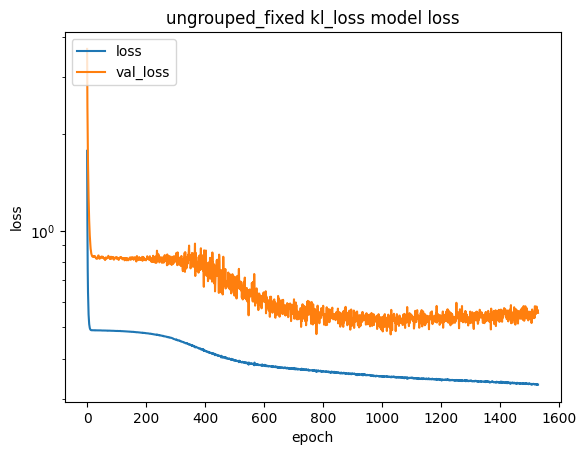

4/4 [==============================] - 0s 2ms/step - loss: 2.8060
EXPECTED:
     d18O_cel_mean  d18O_cel_variance
0        25.120750           0.844007
1        25.120750           0.844007
2        25.120750           0.844007
3        25.120750           0.844007
4        25.120750           0.844007
5        25.120750           0.844007
6        25.120750           0.844007
7        25.120750           0.844007
8        25.120750           0.844007
9        25.120750           0.844007
10       25.120750           0.844007
11       25.120750           0.844007
12       25.120750           0.844007
13       25.120750           0.844007
14       25.120750           0.844007
15       25.120750           0.844007
16       25.120750           0.844007
17       25.120750           0.844007
18       25.120750           0.844007
19       25.120750           0.844007
20       25.120750           0.844007
21       25.120750           0.844007
22       25.120750           0.844007
23       25.

2023-07-12 21:21:56.328651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [109,12]
	 [[{{node Placeholder/_0}}]]


In [47]:
ungrouped_fixed = {
    'TRAIN' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_train_fixed_ungrouped.csv",
    'TEST' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_test_fixed_ungrouped.csv",
    'VALIDATION' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_validation_fixed_ungrouped.csv",
}

ungrouped_fixed_scaled = load_and_scale(ungrouped_fixed)
train_and_evaluate(ungrouped_fixed_scaled, "ungrouped_fixed", training_batch_size=1)

### 3) Grouped, random

grouped_random
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 20)           260         ['input_12[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 20)           420         ['dense_22[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_23[0][0]']               
                                                                            

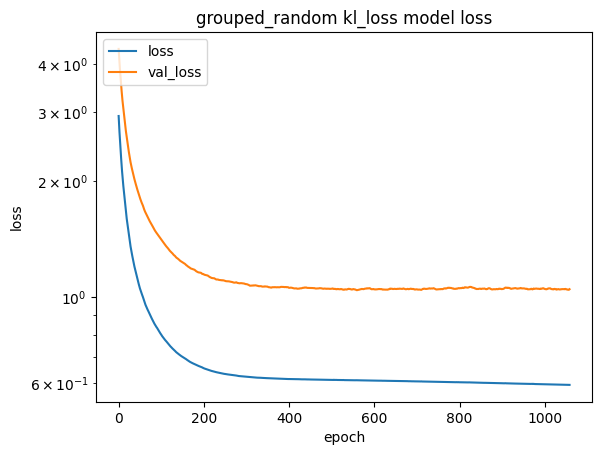

1/1 [==============================] - 0s 87ms/step - loss: 0.6326
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      25.882000           0.233670
1      25.654000           0.334480
2      27.207456           1.041823
3      25.163333           0.807832
4      24.030630           0.579233
5      26.040923           0.222859

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.297815           1.995377
1      25.295967           1.993114
2      25.295794           1.992364
3      25.275953           1.980142
4      25.275953           1.980142
5      25.276161           1.979879
RMSE: 1.0224386535378929


2023-07-12 21:24:15.668695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6,12]
	 [[{{node Placeholder/_0}}]]


In [49]:
grouped_random = {
    'TRAIN' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_train_random_grouped.csv",
    'TEST' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_test_random_grouped.csv",
    'VALIDATION' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_validation_random_grouped.csv",
}

grouped_random_scaled = load_and_scale(grouped_random)
train_and_evaluate(grouped_random_scaled, "grouped_random", training_batch_size=1)

### 4) Grouped, fixed

grouped_fixed
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 dense_24 (Dense)               (None, 20)           260         ['input_13[0][0]']               
                                                                                                  
 dense_25 (Dense)               (None, 20)           420         ['dense_24[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_25[0][0]']               
                                                                             

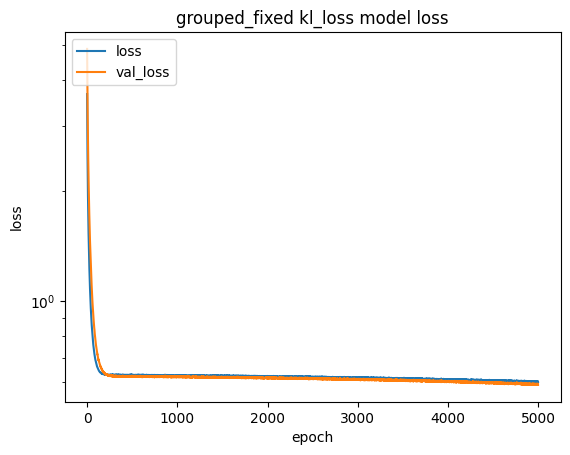

1/1 [==============================] - 0s 83ms/step - loss: 0.8462
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      27.559140           0.780698
1      27.260748           0.830341
2      24.777670           0.736571
3      25.987815           5.280825
4      25.551850           0.312355
5      25.115885           0.033519
6      24.132031           0.389042
7      25.120750           0.844007

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.221792           1.622524
1      25.228788           1.622464
2      25.315172           1.678207
3      25.308834           1.686496
4      25.313841           1.685640
5      25.316624           1.685155
6      25.314953           1.685449
7      26.073936           1.463726
RMSE: 1.262279188208054


2023-07-12 21:39:22.891488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8,12]
	 [[{{node Placeholder/_0}}]]


In [50]:
grouped_fixed = {
    'TRAIN' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_train_fixed_grouped.csv",
    'TEST' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_test_fixed_grouped.csv",
    'VALIDATION' : "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001/amazon_sample_data/uc_davis_2023_08_12_validation_fixed_grouped.csv",
}

grouped_fixed_scaled = load_and_scale(grouped_fixed)
train_and_evaluate(grouped_fixed_scaled, "grouped_fixed", training_batch_size=1)